Run the classical response to sinusoidal forcing. This use the dirichlet solver of the diffusion equation.

In [1]:
import sys

%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

sys.path.append("..")
from mfm import MeteoData, Parameters, model_dirichlet, depth

In [2]:
nlyr_snow = 60  # layers are 1cm thick
rho_snow = [400]
ks_snow = [0.25]

nlyr_soil = 1000 # 10 m
rho_soil = 400.
cp_soil  = 2000.
ks_soil   = 0.25

mean_tair = 250
tbase = 250
amplitude_tair = 10

nlyr = nlyr_snow + nlyr_soil

params = Parameters(dt=100,
                   albedo=0.85,
                   z0=0.01,
                   zt=2.0,
                   dx=1e-2 * np.ones(nlyr),
                   cp=np.array([152.75 + 7.1 * mean_tair] * nlyr_snow + [cp_soil] * nlyr_soil),  # for the ice and soil
                   ks=np.array([ks_snow[0]]*nlyr_snow + [ks_soil]*nlyr_soil),
                   rho=np.array([rho_snow[0]]*nlyr_snow + [rho_soil]*nlyr_soil),
                   tbase=tbase,
                   V = 3 #Wm -2 K -1
                  )

z = depth(params) + nlyr_snow*1e-2
#iz_output = [nlyr_snow - z for z in z_output]

time = pd.date_range("2013-01-01", "2013-04-01", freq="100S")

def meteo_iterator():
    w = 2*np.pi/(24*3600)
    for dt in time:
        ts = mean_tair + amplitude_tair * np.cos(w * (dt-time[0]).total_seconds())
        yield dt, ts
    
# theoretical solution for a homogeneous medium
def diffusion(z, dt):
    w = 2*np.pi/(24*3600)
    D = ks_snow[0]/(rho_snow[0]*params.cp[0])
    t = np.array(dt.total_seconds())
    d = np.sqrt(2*D/w)
    rz = nlyr_snow*params.dx[0] - z
    temp = mean_tair +  amplitude_tair * np.exp(-rz/d) * np.cos(w*t - rz/d)
    return temp

In [3]:
# run the model

temp_arr = []
temp = None

i = 0
o_time = []
for dt, ts in meteo_iterator():
    if temp is None: # initialization
        temp = np.concatenate((np.linspace(mean_tair, tbase, nlyr_snow), 
                               np.linspace(tbase, tbase, nlyr_soil)))
    for j in range(0, 100, params.dt):
        if (j % 3600) == 0:  # output temperature every hour
            o_time.append(dt + np.timedelta64(j, 's'))
            temp_arr.append(temp)
        temp = model_dirichlet(ts, temp, params)
        
    i+=1
    
temp_arr = np.array(temp_arr)
o_time = pd.DatetimeIndex(o_time)
temp_arr.shape

(77761, 1060)

<IPython.core.display.Javascript object>


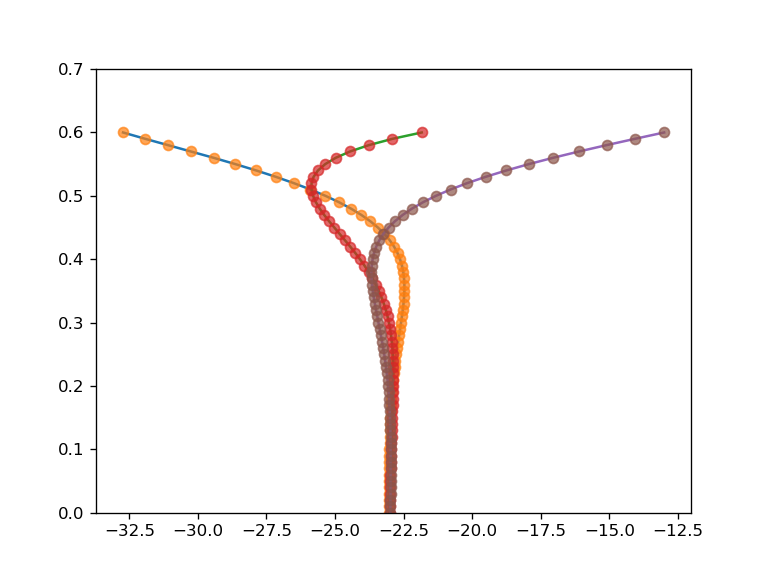

<IPython.core.display.Javascript object>


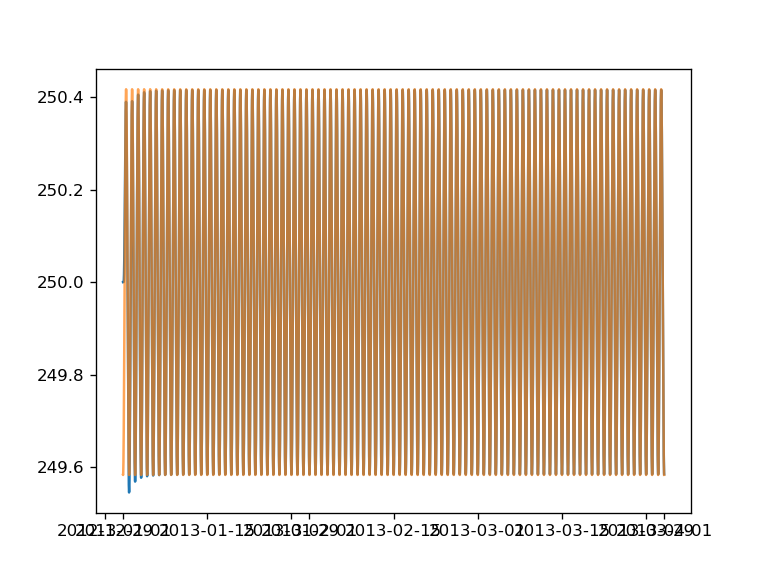

In [4]:
plt.figure()

for jtime in [-400, -200, -1]:
    plt.plot(temp_arr[jtime,:]-273, z)
    plt.plot(diffusion(z, o_time[jtime-1]-o_time[0])-273, z, 'o', alpha=0.7)

plt.ylim((0, 0.7))


i = 30
plt.figure()
plt.plot(o_time, temp_arr[:, i])
plt.plot(o_time, diffusion(z[i], o_time-o_time[0]), alpha=0.7)
